# ART RECOMMENDER SYSTEM

## Analysing Data - Both Museums (MET & Prado)

After trying to build a personalized Word2Vec translator in step [Building s Translator - Word2Vec](05_Museums_Word2Vec.ipynb) and not getting accurate results we will try using pre-existing Word Vectors to translate one ef the Datasets.

This script will take all the data retrieved from [Importing and Cleaning Data - Prado](02_Prado_LoadClean.ipynb) and traslate it using [MUSE Project](https://github.com/facebookresearch/MUSE) Word Vectors, join it with the data from [Importing and Cleaning Data - MET](01_MET_LoadClean.ipynb) and create a new topic model with a bigger, one language, dataset.  

After getting a unified topic model, the results will be used to build a recommender system for works of art from one museum to the other.

In [1]:
import pickle
import nltk
import io
import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join
from sklearn import decomposition
from sklearn import feature_extraction
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer


### Load Met Data

In [2]:
mypath = '../MetFiles/'
onlyfiles = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])
len(onlyfiles)

34

In [3]:
met_df = []
for p in onlyfiles[1:] :
    with open(mypath + p, 'rb') as f:
        met_df = met_df + pickle.load(f)
met_df = pd.DataFrame(met_df, columns=['link', 'descripcion', 'ent'])
met_df.head()

,link,descripcion,ent
0,http://www.metmuseum.org/art/collection/search...,"Until the mid-1870s, furniture styles in Ameri...",None
1,http://www.metmuseum.org/art/collection/search...,"This cabinet was a gift of its maker, Charles ...",None
2,http://www.metmuseum.org/art/collection/search...,With the development of new formulas and techn...,None
3,http://www.metmuseum.org/art/collection/search...,With the development of new formulas and techn...,None
4,http://www.metmuseum.org/art/collection/search...,With the development of new formulas and techn...,None


In [4]:
#Eliminar duplicados
print(len(met_df))
met_df=met_df.drop_duplicates('descripcion').reset_index()
print(len(met_df))

75455
41539


### Load Prado Data and join them together

In [5]:
mypath = '../PradoFiles/'
onlyfiles = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])
onlyfiles

['Prado_descriptions_9119.pkl',
 'Prado_descriptions_9400.pkl',
 'Prado_descriptions_9990.pkl']

In [6]:
prado_df = []
for p in onlyfiles :
    with open(mypath + p, 'rb') as f:
        prado_df = prado_df + pickle.load(f)
prado_df = pd.DataFrame(prado_df, columns=['titulo', 'link', 'descripcion'])
prado_df.tail()

,titulo,link,descripcion
9985,Lot embriagado por sus hijas,https://www.museodelprado.es/coleccion/obra-de...,"Lot sentado de frente, con una de sus hijas so..."
9986,Grupo de ancianos de ''San Pablo predicando en...,https://www.museodelprado.es/coleccion/obra-de...,
9987,Vista de la laguna veneciana con barcos,https://www.museodelprado.es/coleccion/obra-de...,"En el primer término varios barcos y góndolas,..."
9988,Estudio de mano apoyada en una rodilla,https://www.museodelprado.es/coleccion/obra-de...,Recién llegado a Roma como pensionado de la Re...
9989,Soldado arrodillado de perfil en posición de a...,https://www.museodelprado.es/coleccion/obra-de...,Dibujo preparatorio para la composición de La ...


In [7]:
#Eliminar duplicados
print(len(prado_df))
prado_df = prado_df.drop_duplicates('descripcion').reset_index()
print(len(prado_df))

9990
6965


## Transator (MUSE)

In [2]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

**The following Word Vectors were downloaded from the [MUSE Project Github](https://github.com/facebookresearch/MUSE)**

In [4]:
src_path = '../utils/wiki.multi.es.vec.txt'
tgt_path = '../utils/wiki.multi.en.vec.txt'

nmax = 200000  # Load all of them!

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)
word2id = {v: k for k, v in src_id2word.items()}

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

word_plot = PCA(n_components=2, whiten=True)  
#word_plot =  TSNE(n_components=2, n_iter=3000, verbose=2)
word_plot.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % word_plot.explained_variance_ratio_.sum())

Variance explained: 0.06


In [6]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

**Test and plot some words**

In [8]:
src_word = 'árbol'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "arbol":
0.6240 - tree
0.5325 - trees
0.4342 - gnarled
0.4313 - sprouting
0.4274 - shrubbery


In [21]:
import matplotlib.pyplot as plt

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)
    
    # find tsne coords for 3 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    fig = plt.figure(figsize=(10,10))
    plt.scatter(x_coords, y_coords, marker='^')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'red' if k < len(src_words) else 'gray'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    
    plt.show()

<Figure size 800x640 with 0 Axes>

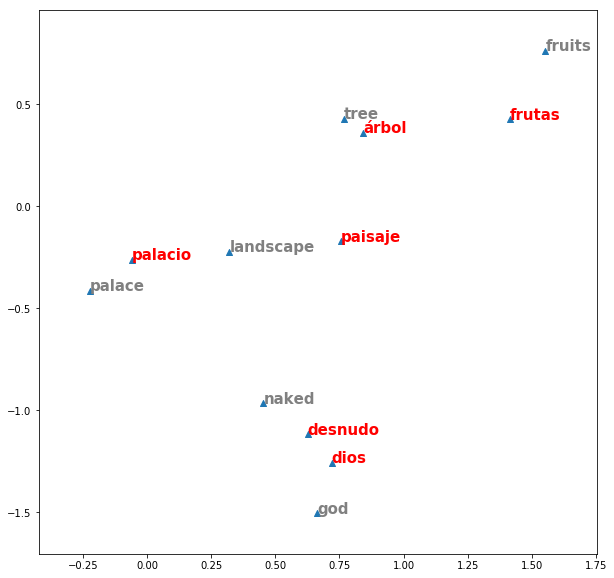

In [22]:
from sklearn.decomposition import PCA
tgt_words = ['palace', 'tree', 'fruits', 'landscape', 'god', 'naked']
src_words = ['palacio', 'árbol', 'frutas', 'paisaje', 'dios', 'desnudo']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, word_plot)

### Translate Prado dataset (Spanish) to English

In [10]:
def translate_word(word, src_emb, tgt_emb, tgt_id2word):
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-1:][::-1]
    
    return tgt_id2word[k_best[0]]

In [11]:
# Dejar acentos!
src_word = 'árbol'
translate_word(src_word, src_embeddings, tgt_embeddings, tgt_id2word)

'tree'

In [12]:
from string import punctuation
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation).lower()

In [13]:
def transtate_desc(desc) :
    trans_res = []
    for w in desc.split() :
        w = strip_punctuation(w)
        try :
            trans_res.append(translate_word(w, src_embeddings, tgt_embeddings, tgt_id2word))
        except :
            trans_res.append(w)
            continue
    return ' '.join(trans_res)

In [12]:
transtate_desc('hola me llamo monica y esto es una prueva de pintura')

'fyi me sorry monica and that is a prueva of painting'

In [13]:
print(prado_df['descripcion'][0])
print('-'*30)
print(transtate_desc(prado_df['descripcion'][0]))

El conjunto de las pinturas murales de la ermita de la Vera Cruz de Maderuelo (Segovia) fue trasladado a lienzo en 1947 y reconstruido en el Museo del Prado lo más fielmente posible a su disposición original. Los muros de la capilla están decorados con figuras de ángeles, Apóstoles y escenas evangélicas, y los testeros presentan dos temas bíblicos: Bóveda, centro: El Pantocrátor sostenido por cuatro ángeles; lateral izquierdo: La Anunciación, Ángel turiferario, San Mateo y San Lucas. Lateral derecho: San Marcos, Ángel con rollo, ¿San Juan Evangelista?, Ángel turiferario, Ángel con libro, Santo obispo. Medios puntos: Caín (para algunos autores Melquisedec) y Abel presentan ofrendas al Cordero inserto en la Cruz, La creación de Adán y El Pecado Original. Muro izquierdo: Seis Apóstoles, La Magdalena unge los pies del Señor, Adoración de un Mago a la Virgen con el Niño; Muro derecho: Cuatro Apóstoles. Las figuras representadas, típicamente románicas, no tienen volumen ni profundidad y está

In [99]:
test_df = prado_df.tail()
test_df

,titulo,link,descripcion
9983,Retablo de la dolorosa,https://www.museodelprado.es/coleccion/obra-de...,El altar del dibujo es neoclásico. En el basam...
9985,Lot embriagado por sus hijas,https://www.museodelprado.es/coleccion/obra-de...,"Lot sentado de frente, con una de sus hijas so..."
9987,Vista de la laguna veneciana con barcos,https://www.museodelprado.es/coleccion/obra-de...,"En el primer término varios barcos y góndolas,..."
9988,Estudio de mano apoyada en una rodilla,https://www.museodelprado.es/coleccion/obra-de...,Recién llegado a Roma como pensionado de la Re...
9989,Soldado arrodillado de perfil en posición de a...,https://www.museodelprado.es/coleccion/obra-de...,Dibujo preparatorio para la composición de La ...


In [ ]:
prado_df['en_description'] = prado_df['descripcion'].apply(transtate_desc)

In [14]:
prado_df.head()

,index,titulo,link,descripcion
0,0,El Pantocrátor sostenido por cuatro ángeles. P...,https://www.museodelprado.es/coleccion/obra-de...,El conjunto de las pinturas murales de la ermi...
1,19,Oso. Ermita de San Baudelio. Casillas de Berla...,https://www.museodelprado.es/coleccion/obra-de...,"El Oso, conectado con las fuerzas del mal, gen..."
2,20,Elefante. Ermita de San Baudelio. Casillas de ...,https://www.museodelprado.es/coleccion/obra-de...,El Elefante simboliza la humildad y se relacio...
3,21,Cacería de liebres. Ermita de San Baudelio. Ca...,https://www.museodelprado.es/coleccion/obra-de...,"En esta Cacería de liebres, el cazador, a caba..."
4,22,Soldado o montero. Ermita de San Baudelio. Cas...,https://www.museodelprado.es/coleccion/obra-de...,El Soldado o montero se representa armado con ...


In [ ]:
en_desc = []
c=0
for row in prado_df['descripcion'] :
    en_desc.append(transtate_desc(row))
    #print(row)
    if (c%200 == 0) :
        print(c)
    c+=1

In [ ]:
test_df

In [7]:
#Aqui tengo solo los textos
met_desc = [x[1] for x in met_df if x[1] != '']
len(met_desc)

74322

In [8]:
#Eliminar duplicados
met_desc = list(set(met_desc))
total = len(met_desc)
total

41538

# TFIDF Analysis to all the dataset

**Stop Words**  
(Stop words in spanish were downloaded from [here](https://github.com/stopwords-iso))

In [35]:
from nltk.corpus import stopwords

#Spanish
with open('../utils/stopwords-es.txt') as f:
    stop_words_es = f.readlines()
stop_words_es = [sw.replace('\n', '') for sw in stop_words_es]
stop_words_es += 'a b c d e f g h i j k l m n ñ o p q r s t u v w x y z'.split()
stop_words_es += 'i ii iii iv v vi vii viii ix x xi xii xiii xiv xv xvi xvii xviii xix xx pp'.split()
stop_words_es += 'first second third fourth fifth sixth seventh eigth ninth tenth twelfth sixteenth seventeenth eighteenth nineteenth twenty twientieth'.split()
stop_words_es += 'january february march april may june july august september october november december'.split()

##English
stop_words_en = stopwords.words('english')
stop_words_en = stop_words_en + stop_words_es 
stop_words_en += 'one two three four five six seven eight nine ten'.split()
stop_words_en += 'museum museums met work works painting paintings artist artists drawing drawings canvas art arts \
                painter painters century centuries period periods decade decades picture pictures since life lives \
                architecture architecturally project projects common throughout full across however popular name names ca mid tip \
                aspect aspects image images imagery various known technique techniques scene scenes time times \
                develop develops developed depeloping theme themes topic topics overall show showed shows showing shown important \
                commission commissioned commissioning commissions treatment serie series notebook notebooks tone tones \
                left right top bottom up upper down front behind back high highly low group around among surrounded half middle \
                typical state states rare identity identities slight slightly self type types additional version \
                year years catalog catalogs exposition expositions similar idea ideas author authors element elements \
                master masters academy academies character characters inferior superior effect effects color colors \
                model models evident relation relations relate related relates relationship relationships bound \
                characteristic characteristics characterized format formats copy copies note notes noted noting \
                charge charges intended active actives part parts apart proofs site sites event events region regions \
                which inventory inventories position positions positioned positioning text texts relief form forms \
                big large small short short great thin wide widely thick narrow stretch round deep underneath \
                profile profiles these another other feature features still instead near far detail details sort sorts \
                could together rather surface surfaces traditional shape shapes object objects even mayor minor \
                line lines fine past future impression impressions photo photos famous copyright motif motifs \
                vivacity worth thematic spontaneity spontaneous surprisingly little movement movements \
                including included includes include create created creates creating composition subject subjects \
                express expressed expresses expressing expression appear appears appeared appearing piece pieces \
                producing produced produces produce product production probably long set sets example examples \
                publish publishes published publishing public de des study studio studies semi also within much \
                portrait portraits page pages source sources interesting uninteresting constrained edition editions \
                et co cm center central side sides issue well collection collections many few several style styles \
                often among although around would different school schools date dates dated base bases based \
                pictoric pattern patterns ocassion ocassions almost without upon either whose perhaps new \
                angle angles case cases some difference differences icon icons iconography interior exterior \
                especial especially sure surely possible possibly particular particularly original originally \
                content contents early earlier late later title titles titled like likely seem seemingly \
                pose poses posed posing usually usual unusually unusual area areas sheet sheets paper papers volume volumes \
                attribution attributed attribute attributes attributing print printed prints printing \
                contain contains contained containing content paint paints painted find found finds finding \
                design designs designed designing designer designers figure figures figured figuring \
                create creates created creating associate associates associated associating \
                issue issues issued issuing horizontal vertical border borders flanked variety varieties \
                extract extracts extracted extracting give gave gives giving end ends ended ending cut cuts cutting \
                represent represented represents representing present presented presents presenting \
                finish finished finishes finishing sustain sustained sustains sustaining hold held holds holding \
                allow allowed allowes allowing remember remembered remembers remembering begin began begins beginning \
                inscribe inscribed inscribes inscribing cover covered covers covering make made makes making \
                place placed places placing worked working became becomes becomming put puts putting \
                admire admired admires admiring donated donation donate donating use uses used using \
                adapt adapted adapts adapting call called calls calling see saw sees seem seen seeing \
                compose composed composes composing suggest suggested suggests suggesting suggestion suggestions \
                depict depicts depicted depicting distribute distributes distributed distributing \
                inspire inspires inspired inspiring elaborate elaborates elaborated elaborating elaborately \
                view viewed views viewing execute executes executed executing write wrote writes written writing \
                render rendered renders rendering process processed processes processing match matches matched matching \
                demonstrate demonstrates demostrated demosntrating derive derives derived deriving remain remains remained remaining \
                reveal reveals revealed revealing replace replacing replaced replaces abstract abstracted abstracts abstracting \
                decorate decorates decorated decorating register registers registered registering exhibit exhibits exhibited exhibiting \
                size sized sizes sizing insert inserts inserted inserting promote promotes promoted promoting \
                label labels labeled labeling comprise comprises comprised comprising limit limited limits limiting \
                etch etches etched etching belong belonged belongs belonging grant granted grants granting \
                spend spends spent spending consist consisted consists consisting alternate alternated alternates alternating \
                republish republishes republished republishing dispense dispensed dispenses dispensing supply supplies supplied supplying \
                last lasted lasts lasting pursue pursued pursues pursuing introduce introduces introduced introducing \
                balance balances balanced continue continued continues continuing purchase purchases purchased purchasing \
                chose choses chosed chosing chosen live lives lived living combine combined combines combining \
                turn turns turned turning add adds added adding reach reaches reached reaching draw drawn drew drawing \
                look looks looked looking bring brang brings bringing incorporate incorporates incorporated incorporating \
                indicate indicates indicated indicating come came comes coming describe describes described describing \
                prevail prevailed prevails prevailing understand understands understood understanding understandings'.split()
stop_words_en = set(stop_words_en)

In [36]:
idf_vectorizer = feature_extraction.text.TfidfVectorizer(
    ngram_range=(1, 1),
    stop_words=stop_words_en,
    token_pattern="\\b[a-z][a-z]+\\b",
    min_df=0.00002,
    max_df=0.20
)
counts = idf_vectorizer.fit_transform(met_desc)

In [37]:
feature_names = idf_vectorizer.get_feature_names()
print(f"""
number of features: {len(feature_names):,}
random set of features: {np.random.choice(feature_names, size=20)}
""")


number of features: 70,012
random set of features: ['erudite' 'sawaya' 'beni' 'flamboyance' 'hereditary' 'unterschidliche'
 'puming' 'grabbing' 'bosworth' 'ostraka' 'foolhardy' 'minion' 'bulks'
 'visite' 'understudied' 'barons' 'thistle' 'hageshisa' 'map' 'vella']



In [38]:
# Create the term-document matrix
counts = idf_vectorizer.transform(met_desc)
# this gives us a [num_documents, num_features] sparse matrix
counts.shape

(41538, 70012)

## Topic Analysis NMF

In [14]:
from sklearn.cluster import KMeans

x = range(2,21)
y_inertia = []

for k in x:
    km = KMeans(n_clusters=k, init='k-means++', n_init=5, random_state=1, n_jobs=1, max_iter=3)
    km.fit(counts)
    labels = km.labels_
    y_inertia.append(km.inertia_)
    print(k)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'Inertia')

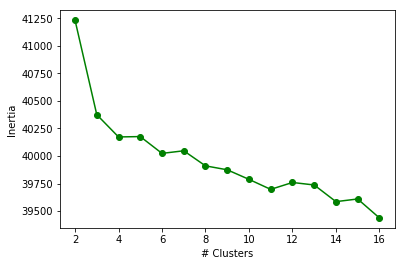

In [16]:
%pylab inline
plt.plot(x[:15], y_inertia[:15], 'go-', )
plt.xlabel('# Clusters')
plt.ylabel('Inertia')

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'Inertia')

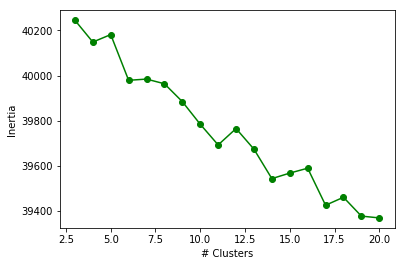

In [129]:
%pylab inline
plt.plot(x, y_inertia, 'go-', )
plt.xlabel('# Clusters')
plt.ylabel('Inertia')

In [41]:
n_topics = 10

In [42]:
from sklearn.decomposition import NMF

model = NMF(n_components=n_topics, init='random', random_state=818)
doc_top = model.fit_transform(counts)

In [43]:
doc_max_top = np.argmax(doc_top, axis=1 )
topic_words = []
for r in model.components_:
    r_normalized = r/sum(r)
    a = sorted([(v,i) for i,v in enumerate(r_normalized)],reverse=True)[0:20]
    topic_words.append([ f"{feature_names[e[1]]}, {e[0]:.2%}"  for e in a])
pd.DataFrame(np.array(topic_words).T)

,0,1,2,3,4,5,6,7,8,9
0,"blue, 1.83%","gold, 2.84%","mail, 7.06%","cards, 23.01%","venice, 3.58%","typography, 9.61%","postcard, 7.57%","dress, 0.20%","league, 6.58%","bread, 5.28%"
1,"textile, 1.73%","jewelry, 2.82%","card, 4.28%","bowman, 15.53%","italian, 3.13%","portfolio, 9.19%","arcade, 6.39%","woman, 0.17%","man, 5.36%","album, 4.54%"
2,"colored, 1.59%","stones, 1.70%","bakery, 3.82%","gum, 15.37%","column, 2.78%","plate, 5.37%","machines, 6.37%","hand, 0.16%","red, 5.13%","company, 4.07%"
3,"green, 1.42%","enamel, 1.37%","carriers, 3.75%","trade, 13.48%","ornamented, 2.23%","dubuffet, 4.81%","chicago, 5.78%","head, 0.16%","tobacco, 4.87%","card, 3.74%"
4,"leaves, 1.38%","pearls, 1.20%","crispy, 3.71%","number, 13.13%","leaves, 1.60%","phenomena, 4.78%","toned, 5.06%","women, 0.15%","player, 4.84%","bakery, 3.66%"
5,"white, 1.30%","glass, 1.14%","stamps, 3.68%","card, 0.57%","flowers, 1.51%","lithographs, 4.41%","card, 4.95%","plate, 0.13%","chewing, 4.62%","baking, 3.45%"
6,"dark, 1.26%","diamonds, 1.08%","gibson, 3.67%","mccormick, 0.52%","giovanni, 1.37%","black, 2.79%","stars, 4.43%","chinese, 0.13%","card, 3.75%","cards, 2.13%"
7,"textiles, 1.16%","frame, 0.89%","collins, 3.65%","bat, 0.47%","columns, 1.35%","white, 2.61%","cards, 4.38%","decoration, 0.13%","trade, 3.54%","loaves, 2.09%"
8,"flowers, 1.13%","precious, 0.82%","freihofers, 3.64%","biscuits, 0.26%","diamonds, 1.30%","arches, 1.16%","mutoscope, 3.76%","haden, 0.13%","team, 3.07%","weber, 1.79%"
9,"brown, 1.06%","jewels, 0.79%","baked, 3.62%","manufacturing, 0.24%","curving, 1.29%","proof, 0.98%","company, 3.68%","saint, 0.13%","baseball, 2.57%","pullman, 1.45%"


In [44]:
c = 0
for d in met_df :
    if 'card' in d[1] :
        print(d)
        c+=1
        #break
100*c/total

('http://www.metmuseum.org/art/collection/search/1423', 'Card tables are more typically associated with parlors and sitting rooms, but these lightweight and versatile objects lent themselves to a variety of activities, from taking tea to conducting correspondence. This card table and its mate, now in a private collection, were produced en suite with a Pembroke table that would have been used for informal meals not requiring a large dining table.')
('http://www.metmuseum.org/art/collection/search/1425', 'The upper playing surface of this rare tripletop gaming table is inlaid with patterns of backgammon and chess boards; the lower one is lined with baize for playing cards. Otherwise, the table is characteristic of a small group of New York card tables with bold serpentine fronts.')
('http://www.metmuseum.org/art/collection/search/1427', 'This turret-top card table, so called for its projecting rounded corners, descended in the Verplanck family along with four side chairs (39.184.3-.6), a

('http://www.metmuseum.org/art/collection/search/435551', 'Trade cards from the "Soldier Cards" series (E7), issued in the 1910s by an unknown candy manufacturer.', '')
('http://www.metmuseum.org/art/collection/search/435552', 'Trade cards from the "Soldier Cards" series (E7), issued in the 1910s by an unknown candy manufacturer.', '')
('http://www.metmuseum.org/art/collection/search/435557', 'Trade cards from the "Soldier Cards" series (E7), issued in the 1910s by an unknown candy manufacturer.', '')
('http://www.metmuseum.org/art/collection/search/435558', 'Trade cards from the "Soldier Cards" series (E7), issued in the 1910s by an unknown candy manufacturer.', '')
('http://www.metmuseum.org/art/collection/search/435559', 'Trade cards from the "Soldier Cards" series (E7), issued in the 1910s by an unknown candy manufacturer.', '')
('http://www.metmuseum.org/art/collection/search/435560', 'Trade cards from the "Soldier Cards" series (E7), issued in the 1910s by an unknown candy manufa

('http://www.metmuseum.org/art/collection/search/661584', 'Trade cards from the set "Actors and Actresses" (N342), Type 4, issued 1880-1892 by Thomas H. Hall Tobacco to promote Between the Acts Cigarettes. There are five types of cards in the series, differentiated by the variation of oval frame surrounding the card subject.', '')
('http://www.metmuseum.org/art/collection/search/661585', 'Trade cards from the set "Actors and Actresses" (N342), Type 4, issued 1880-1892 by Thomas H. Hall Tobacco to promote Between the Acts Cigarettes. There are five types of cards in the series, differentiated by the variation of oval frame surrounding the card subject.', '')
('http://www.metmuseum.org/art/collection/search/661586', 'Trade cards from the set "Actors and Actresses" (N342), Type 4, issued 1880-1892 by Thomas H. Hall Tobacco to promote Between the Acts Cigarettes. There are five types of cards in the series, differentiated by the variation of oval frame surrounding the card subject.', '')
(

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



53.570224854350236

### Plot!

In [221]:
from sklearn.manifold import TSNE
# plot with tsne!

doc_plot = TSNE(verbose=1, metric="cosine").fit_transform(doc_top[::n_topics,:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2600 samples in 0.000s...
[t-SNE] Computed neighbors for 2600 samples in 0.192s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2600
[t-SNE] Computed conditional probabilities for sample 2000 / 2600
[t-SNE] Computed conditional probabilities for sample 2600 / 2600
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.943283
[t-SNE] Error after 1000 iterations: 0.908021


Populating the interactive namespace from numpy and matplotlib


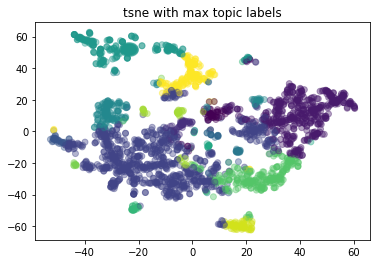

In [222]:
%pylab inline

plt.scatter(doc_plot[:,0],doc_plot[:,1], c=doc_max_top[::n_topics], alpha=.4)
plt.title("tsne with max topic labels")
plt.savefig("../img/TSNE_Met_NMF_DF_Full.pdf")

In [53]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

### My Topics. (Analizar y ponerles nombre)

In [67]:
print_top_words(lda, count_vectorizer.get_feature_names(), 10)

Topic #0: lamp ar fanshaw stewardson sevy richard marry rebecc richard sevy jr john sevy pearc liv liv provid
Topic #1: gothic arch dish reflect pattern press press thi reflect goth arch pattern past merit touch ground test past hand cal
Topic #2: gray hendrickson hendrickson edi gray mii koshij mazu katad sit edi med exhibit paint irvin
Topic #3: orna style fam fir staircas instal form chicago execut vary style combin canva mold typ skyscrap ironwork exempl architect led
Topic #4: betel uchid hunz betel nut lim slight narcot print fan pan refresh lim condy nut powd
Topic #5: marcot worsham rockefel par new ludlow john carp bennet trans john trans match sid
Topic #6: quilt cotton wov bord piec wool block fabr coverlet stitch
Topic #7: crossbow donaldson kouwenhov van kouwenhov westtown son lyd benjamin smallwood smallwood washington lyd hutchinson smallwood
Topic #8: thi paint art new ar wer design work portrait york
Topic #9: manaku buddha esot ar tradit tradit mount vairochan presid 

In [56]:
topic = 1
for doc_i in np.argsort(doc_topics[:,topic])[-3:]:
    print(met_desc[doc_i])
    print("-"*80)

mos chief of the okinok was on of sev portrait of northwest ind that warn model in 1891 whil in oregon in 1893 warn 's friend charl erskin scot wood stat that mos was chief of the ilnamehin or okinak trib a loc branch of the nez perc nat in fact the okanagon belong to the inland divid of the sal lingu stock in the pac northwest becaus of a striking resembl mos was oft nicknam henry ward beech warn 's abl to us light and shad to model the text of mos 's skin and hair attest to the sculpt ’ s mastery of the bronz med
--------------------------------------------------------------------------------
young chief cayus ind was on of sev portrait of northwest ind that warn model in 1891 whil in oregon when poor cran chief of the cayus died young chief who was liv on the umatill reserv becam head of the trib and held the posit until his dea in 1901 in contrast to poor cran selt and the oth old ind whom warn depict young chief repres a young gen who had adopt a euro-american lifestyl warn 's abl